In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import os
# Any results you write to the current directory are saved as output.

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization, Dropout
from keras.initializers import HeNormal

In [34]:
df=pd.read_csv("train.csv")
df.head()

,left,right
0,aaa,osr
1,aaz,mqw
2,abh,cdx
3,abn,uzp
4,abq,bbd


In [35]:
print("Number of samples: ",len(df))

Number of samples:  2000


In [36]:
# sns.distplot(df.has_cactus)

In [37]:
from PIL import Image
from skimage.transform import resize
import random

In [38]:
import os

# 指定你想要列出文件的目录路径
directory_path = 'train/right'

# 使用os.listdir()获取目录中的所有文件和子目录名
all_items = os.listdir(directory_path)

# 过滤出只是文件的名字，不包括子目录
file_names = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]

print(len(file_names))

2000


In [39]:
train_data = []
for i in range(2000):
    temp = []
    right_list = []
    left_path = df.left[i] + '.jpg'
    right_path = df.right[i] +'.jpg'
    temp.append(left_path)
    temp.append(right_path)
    right_list.append(right_path)
    temp.append(0)
    train_data.append(temp)
    for j in range(4):
        temp = []
        while True:
            right_path = df.right[random.randrange(2000)] +'.jpg'
            if right_path not in right_list:
                temp.append(left_path)
                temp.append(right_path)
                right_list.append(right_path)
                temp.append(1)
                train_data.append(temp)
                break

In [43]:
len(train_data)

50000

In [42]:
train_data = train_data * 5

In [44]:
class ProjectDataGenerator(Sequence):
    def __init__(self, root_path, data_list, datagen, target_size=(80,98), batch_size=32, shuffle=True):
        self.root_path = root_path
        self.data_list = data_list
        self.datagen = datagen
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data_list) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = [self.data_list[i] for i in batch_indices]
        
        batch_images_1 = []
        batch_images_2 = []
        batch_labels = []

        for data in batch_data:
            img1_path, img2_path, label = data
            img1 = image.load_img(self.root_path+'/left/'+img1_path, target_size=self.target_size, color_mode = "grayscale")
            img2 = image.load_img(self.root_path+'/right/'+img2_path, target_size=self.target_size, color_mode = "grayscale")

            x1 = image.img_to_array(img1)
            x2 = image.img_to_array(img2)

            # Apply data augmentation
            x1 = self.datagen.random_transform(x1)
            x2 = self.datagen.random_transform(x2)

            batch_images_1.append(x1)
            batch_images_2.append(x2)
            batch_labels.append(label)

        return [np.array(batch_images_1), np.array(batch_images_2)], np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,        # Randomly rotate images in the range (degrees, 0 to 180)
    # width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    # shear_range=0.2,         # Randomly apply shearing transformations
    # zoom_range=0.2,          # Randomly zoom inside pictures
    # horizontal_flip=True,    # Randomly flip half of the images horizontally
    # fill_mode='nearest'      # Strategy used for filling in newly created pixels
)
train_root = 'train'
train_generator = ProjectDataGenerator(train_root, train_data, train_datagen, batch_size=32, shuffle = True)

(80, 98, 1)


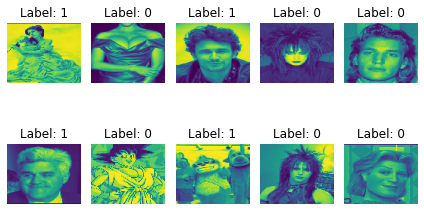

In [48]:
data = train_generator[0]  # 这实际上是调用__getitem__方法的另一种方式
images, labels = data
images_1, images_2 = images

print(images_1[0].shape)

for i in range(5):  # 显示前5张图片作为示例
    plt.subplot(2, 5, i+1)
    plt.imshow(images_1[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

# 显示Batch Images 2中的前几张图片
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(images_2[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [50]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    
    # 第一个卷积-池化块
    x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=HeNormal())(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    # 第二个卷积-池化块
    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    # 第三个卷积-池化块
    x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    # 全连接层
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    return Model(input, x)

In [51]:
# 计算欧几里得距离
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

In [52]:
# 定义孪生网络结构
# 从生成器中获取一个批次的数据
sample_batch = train_generator[0]
sample_images, _ = sample_batch
sample_image = sample_images[0][0]  # 获取第一个批次中的第一张图像

# 从样本图像中提取输入形状
input_shape = sample_image.shape
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [53]:
# def contrastive_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)  # 转换y_true为float32类型
#     margin = 1
#     square_pred = tf.square(y_pred)
#     margin_square = tf.square(tf.maximum(margin - y_pred, 0))
#     return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [54]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=contrastive_loss)

In [ ]:
# 训练模型
model.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator))

Epoch 1/10
1563/1563 [==============================] - 488s 312ms/step - loss: 116.2024
Epoch 2/10
1563/1563 [==============================] - 492s 315ms/step - loss: 0.7255
Epoch 3/10
1563/1563 [==============================] - 501s 321ms/step - loss: 0.1608
Epoch 4/10
1563/1563 [==============================] - 502s 321ms/step - loss: 0.1606
Epoch 5/10
1563/1563 [==============================] - 507s 325ms/step - loss: 0.1607
Epoch 6/10
1563/1563 [==============================] - 502s 321ms/step - loss: 0.1609
Epoch 7/10
1563/1563 [==============================] - 504s 323ms/step - loss: 0.1610
Epoch 8/10
 534/1563 [=========>....................] - ETA: 5:51 - loss: 0.1615

In [ ]:
# distances = model.predict([np.repeat(test_images[0:1], len(train_images), axis=0), train_images])
# closest_index = np.argmin(distances)

In [ ]:
test_pair=pd.read_csv("test_candidates.csv")
test_data = []
for i in range(len(test_pair)):
    left_path = test_pair.left[i] + '.jpg'
    for j in (test_pair.loc[i,"c0":"c19"]):
        temp = []
        right_path = j + '.jpg'
        temp.append(left_path)
        temp.append(right_path)
        temp.append(0)
        test_data.append(temp)

In [ ]:
test_data[0:40]

In [ ]:
# 创建一个没有数据增强的ImageDataGenerator实例
test_datagen = ImageDataGenerator(rescale=1./255)

# 使用ProjectDataGenerator为测试数据创建数据生成器
test_root = 'test'  # 如果你的测试数据在不同的目录，请更改此路径
test_generator = ProjectDataGenerator(test_root, test_data, test_datagen, batch_size=32, shuffle=False)

In [ ]:
data = test_generator[0]  # 这实际上是调用__getitem__方法的另一种方式
images, labels = data
images_1, images_2 = images

for i in range(5):  # 显示前5张图片作为示例
    plt.subplot(2, 5, i+1)
    plt.imshow(images_1[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

# 显示Batch Images 2中的前几张图片
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(images_2[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator))

In [ ]:
print(len(predictions))

In [ ]:
print(predictions[:200])

In [ ]:
import pandas as pd

# 创建一个新的DataFrame
df = pd.DataFrame(test_data, columns=['left_image', 'right_image', 'label'])

# 删除不需要的列
df = df.drop(columns=['label'])

# 创建一个新的DataFrame来存储结果
result_df = pd.DataFrame(columns=['left'] + [f'c{i}' for i in range(20)])

# 对left_image进行分组
grouped = df.groupby('left_image')

# 初始化一个索引来跟踪predictions列表中的位置
index = 0

# 对于每个left_image，将其对应的right_image的预测值放入c0到c19列中
for name, group in grouped:
    # 去除.jpg后缀
    cleaned_name = name.replace('.jpg', '')
    row = [cleaned_name]
    for _, g_row in group.iterrows():
        # 从predictions列表中获取预测值
        prediction = 1 - predictions[index][0]
        if prediction < 0:
            row.append(0)  # 从子列表中获取值
        else:
            row.append(prediction)  # 从子列表中获取值
        index += 1
    result_df.loc[len(result_df)] = row

In [ ]:
result_df.to_csv('predict.csv', index=False)

In [30]:
count = 0
for i in range(len(predictions)):
    if 1 - predictions[i][0] >1:
        print(1 - predictions[i][0])
        print(i)
        count += 1

In [31]:
count

0